# Using refellips to model spectroscopic imaging ellispometry data

The Python library [refellips](https://github.com/refnx/refellips) can be used to model spectroscopic ellipsometry data using user defined models and dispersion curves, affording a lot of freedom to the user. The docs can be read [here](https://refellips.readthedocs.io/en/latest/) and they are quite thorough and include several examples of using it to model different systems.

It has the function `open_EP4file()` for directly reading Accurion EP4 ellipsometry data; however, it has no so function that works with the imaging data. The below code gives it this functionality, although issues remain, which will be discussed below.

### ALSO
I don't recommend running the code inside this notebook, just put it all into a separate *.py file. It might work fine but I wouldn't be too sure I would trust it with the parallelisation inside a notebook, I only tested it in a standard *.py file. 

### The first issue

In order to access the data stored in the *.png files given by the Accurion EP4 imaging measurements, it is necessary to use their proprietary `nanofilm` Python library. This can be found in the packages installed on the PC which came with the EP4, and the code can be read there, but I don't know how illegal it would be to recreate it here, so I haven't.

The rest of the packages should be easily available

In [1]:
import numpy as np
import pandas as pd
import os
from nanofilm.ndimage import imread
import time
import matplotlib.pyplot as plt
import pickle

#These are all related to refellips
import refellips
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
import refnx
from refnx.analysis import CurveFitter
from refnx.reflect import Slab
from refellips.dispersion import RI, Cauchy, load_material
from refellips.dataSE import DataSE

#This is to allow for parallelisation
#Modelling is extremely slow without it
from multiprocessing import Manager, Pool 

The below function opens the files of format:

|Lambda|Bandwidth|AOI|ExposureTime|AcquisitionFrameRate|Delta|Psi|Zone|Amin|Pmin|Afix|Pfix|ROIidx|Time|X_pos|Y_pos|

This is the standard format of the *.ds.dat files give by an imaging measurement. For these imaging measurements, the values in Delta and Psi columns are file names for *.png files that are in the same folder which contain the Delta and Psi data.

The below function takes an absolute or relative path to a *.ds.dat file of this format, and returns a tuple of 4 `np.ndarray()` of shape (N_measurements, png_width,png_height), where N_measurements is the number of measurements contained in the imaging measurement e.g. if it was taken for 20 wavelengths, N_measurements = 20. The 4 arrays contain the wavelength values, AOI values, Psi values and Delta values. For each wavelength. 

I did it in this way as all the data measured at each pixel is contained within a 1D slice of each array along the axis of length = N_measurements. This is how I will make it read the data to do the fitting, as explained below.

In [ ]:
def openEP4ImageData(fname : str):
    """
    Opens an EP4 image data file, returning np.ndarray
    corresponding to the lambda, AOI, Delta and Psi values
    for each of the png files
    Args:
        fname (str): filename (full path preferrably) to the 
        .dat file which contains the image data

    Returns:
        4 x np.ndarray: these correspond to the lambda, AOI,
        Delta and Psi data. The shape is (N_measurements,png_width,png_height)
        where N_measurements is the number of measurements taken e.g. number of 
        different wavelengths, and png_width/height is width and height in number of pixels
    """
    df = pd.read_csv(fname,sep='\t', skiprows=[1])
    df = df.drop(['Bandwidth','ExposureTime','AcquisitionFrameRate','Zone','Time','X_pos','Y_pos'],axis=1) #drop irrelevant data
    dir = os.path.dirname(fname)
    delta_array = [] #initialise list for 3D array of png data
    for path in df['Delta']:
        path = os.path.join(dir,path) #create full path
        delta_array.append(imread(path))
    delta_array = np.stack(delta_array) #stack list into 3D numpy array
    # print(delta_array)

    psi_array = []
    for path in df['Psi']:
        path = os.path.join(dir,path) #create full path
        psi_array.append(imread(path))
    psi_array = np.stack(psi_array)

    lambda_array = np.array([df['#Lambda'].values]*delta_array.shape[1])
    #transposition in order to get shape to match that required to line up
    #with stack of png arrays
    lambda_array = np.array(delta_array.shape[2]*[lambda_array]).transpose()

    #duplicate #Lambda and AOI columns into a (20,350,407) shape
    aoi_array = np.array([df['AOI'].values]*delta_array.shape[1])
    #transposition in order to get shape to match that required to line up
    #with stack of png arrays
    aoi_array = np.array(delta_array.shape[2]*[aoi_array]).transpose()

    return lambda_array,aoi_array,psi_array,delta_array

### Fitting the data

The below function actually fits the data. The function is a bit strange, especially considering it takes the model and cuolayer as arguments, but I will try explain why it is like this. 

First of all, the `i,j` values are just pixel locations, and they are used to slice out the right 1D slice of the arrays generated by the `openEP4ImageData()` function above. When actually implemented, this function will be looping all `i,j` values which make up the image height and width respectively. I originally had this loop embedded within the function, so these weren't arguments themselves, but in order to parallelise the function it was easier to take them out. As such, this function only fits a 1D slice of the above mentioned (N_measurements, png_width,png_height) arrays, and then returns the thickness and stderr in thickness at this pixel.

These slices are then flattened, converted to a `pandas.DataFrame`, and all the rows containing any `NaN` values are dropped. This is done as apparently `NaN` values 'play havoc' with the fitting. This was the same sort of code used within the `refellips` built in function `open_EP4file()` so I replicated it here. The data is then converted back into a `numpy.ndarray` using the `pandas.DataFrame.values` object. This does seem very inefficient, but I messed around trying and failing with ways of doing it without converting to a DataFrame but I couldn't get it to work. When I actually measured the time this took it was about 1% of the fitting time so I don't think it is important compared to the total time required. 

The fitting is taken straight from [Getting Started](https://refellips.readthedocs.io/en/latest/getting_started.html#) page on the refellips docs. My fitting is very basic. I used the `least_squares` fitting algorithm here as it is much faster, but it is a local fit, but it says `differential_evolution` is a global fitting algorithm which can be used, which I use when running it on the HPC. 

I use `model` and `cuo_layer` as arguments here, which I don't think is necessary except for the parallelisation. If this is being adapted, it is important that any `Slab` object in the model which had variable quantities (in my case the `cuo_layer`) is included as an argument. 

The function then returns the thickness value and stderr in angstroms calculated for this data at this point. This can of course be changed to return whatever values are required.

It contains a `try: except:` statement as it was giving a weird LinAlg error sometimes which then killed the whole program. To get around this, whenever it would have thrown this error I just get it to return 0s. This error seems to come at points after thermal grooves, so the big change in oxide thickness may have something to do with it, makes it hard to fit or something. 

In [ ]:
def fit_data(args):
    """takes 

    Args:
        args (tuple): tuple containing all the arguments
        i,j: pixel location in *.png of the point to be fitted
        lambda_arr: array of wavelengths generated by openEP4ImageData()
        aoi_arr: array of AOI generated by openEP4ImageData()
        psi_arr: array of Psi values generated by openEP4ImageData()
        delta_arr: array of Delta values generated by openEP4ImageData()
        model: the specific refellips model being used for the fitting
        cuo_layer: the layer being
    Returns:
        tuple: (cuo_thickness,cuo_thickness_stderr)
    """
    i, j, lambda_arr, aoi_arr, psi_arr, delta_arr,model,cuo_layer = args
    data = (lambda_arr[:,i:i+1,j:j+1].flatten(),
            aoi_arr[:,i:i+1,j:j+1].flatten(),
            psi_arr[:,i:i+1,j:j+1].flatten(),
            delta_arr[:,i:i+1,j:j+1].flatten())
    data = pd.DataFrame(data).dropna(axis=1,how='any')
    data = data.values

    try:
        objective = ObjectiveSE(model,data)
        fitter = CurveFitter(objective)
        fitter.fit('differential_evolution')
        return cuo_layer.thick.value, cuo_layer.thick.stderr
    except Exception:
        return 0,0

This function just gets the image width and height so the 1D array of values we generate later on can be reshaped back into our image. The last function is what will be used to do that. It probably doesn't need to be its own function but it made it easier for me to follow. 

In [ ]:
def get_im_width(image_path : str):
    image_array = imread(image_path)
    return np.shape(image_array)[1]

def get_im_height(image_path : str):
    image_array = imread(image_path)
    return np.shape(image_array)[0]

def get_image_dimensions(fname : str):
    """Generates the width and height of an image in pixels

    Args:
        fname (str): file path of *.ds.dat file containing imaging data

    Returns:
        tuple: (int,int) = (width,height)
    """
    df = pd.read_csv(fname,sep='\t', skiprows=[1])
    dir = os.path.dirname(fname)
    path = df['Delta'][1] #taking a sample path
    print(path) 
    path = os.path.join(dir,path) #create full path
    return get_im_width(path),get_im_height(path)

def data_arr_to_2D(value_arr : list,im_width,im_height):
    return np.reshape(value_arr,[im_height,im_width])

### The main chunk of the file

Here, I have included `if __name__ == '__main__'`:

This is highly recommended in the docs of [multiprocessing](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool), the Python library I will be using for parallelisation. All it does is ensures that this stuff is only ran if this Python program is RAN; if its imported into another program it won't run what is below this, but it will run everything above this.

Please not that all the code below this will have to be indented in an actual *.py file

First, I just grab the time so I will be able to have a time measurement for the full fitting process. 

Then I define the path to my *.ds.dat file

I also define the path to the dispersion files for Cu and CuO. I got this either directly from the Accurion EP4 PC or the [Sopra database](http://www.sspectra.com/sopra.html); I believe that the Accurion dispersion files mention that they were taken from Sopra anyway so shouldn't matter. Note that the dispersions have to be in *.csv format with the first column being wavelength IN MICRONs (this was something that I messed up), second being n values and third being k values. As said in the [refellips docs](https://refellips.readthedocs.io/en/latest/getting_started.html#Creating-a-model-for-our-interface), you can also define a Cauchy curve, among other things. 

In [ ]:
if __name__ == '__main__':
    start = time.time()
    fname = r"C:\Users\lb958\Data\2023_01_09_Cu_after_2weeks\maps\Cu_Tile_longbreak_run01_20230109-171343.ds.dat"
    cu_disp_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Documents\Mini Project 1\Cu-Copper_0.19-2.48micron.csv"
    cuo_disp_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Documents\Mini Project 1\CuO-Copper-II-oxide - cupric oxide_0.30-2.48micron.csv"

Here I have generated the `RI` objects from the dispersion files for air, which is included in the refellips library as seen below, Cu and CuO, which are loaded in by my file path defined above

In [ ]:
    #returns the path of the refellips package being used so can
    #access their built in materials folder
    refellips_path = os.path.dirname(refellips.__file__)
    air = RI(os.path.join(refellips_path,'materials/air.csv'))

    cu = RI(cu_disp_path)
    cuo = RI(cuo_disp_path)

Here I basically just copied what they did in their [Getting Started](https://refellips.readthedocs.io/en/latest/getting_started.html#Creating-a-model-for-our-interface) guide to define my CuO layer and assemble the model

In [ ]:
    cuo_layer = cuo(50) #this sets the thickness to 50 Ang to begin with

    cuo_layer.name = 'CuO'
    #vary thickness between 0-1000 Ang
    cuo_layer.thick.setp(vary=True,bounds=(0,1000))
    cuo_layer.vfsolv.setp(vary=False,value=0) #we have no solvent 

    #build the structure
    structure = air() | cuo_layer | cu()

    model = ReflectModelSE(structure)

This is the bit of code that does the actual fitting, running the `fit_data()` defined above. The first line just gets the image size, then the arrays used for the fitting are generated

I have a `multiprocessing.Manager()` object created and this was meant to allow for sharing of the `model` and `cuo_layer` objects between the different processes which run simultaneously. For some reason, which I don't recall, I commented it out. The code seems to work with it commented out and included, so I am not sure if it is really necessary. 

I use `multiprocessing.pool.Pool()` to parallelise the code. With it as written, the code will use all available CPU cores, but the number used can be chosen as described [here](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool). This slows down my laptop pretty significantly when it's running. 

With everything as it is, each image takes about an hour, or just under, to run on my laptop, so still quite slow. Using a different fitting algorithm would change that, and obviously different PCs with different CPUs will take different amounts of time. When fitting a full range of 10+ measurements I'm doing it on the HPC. It could be done on my laptop if left to run overnight but letting it run on the HPC with a better fitting algorithm works for me. 

In [ ]:
    im_width,im_height = get_image_dimensions(fname)
    lambda_arr,aoi_arr,psi_arr,delta_arr = openEP4ImageData(fname)
    # with Manager() as manager:
    #     shared_model = manager.Namespace()
    #     shared_cuo = manager.Namespace()
    #     shared_model.model = model
    #     shared_cuo.cuo_layer = cuo_layer
    with Pool() as p:
        data = [(i, j, lambda_arr, aoi_arr, psi_arr, delta_arr,model,cuo_layer) for i in range(im_height) for j in range(im_width)]
        results = p.map(fit_data, data)


Here I save the results in 1D arrays, and print the total time taken. Note that the number of CPU cores isn't actually the amount used, but rather the total amount available, so if you change the amount used by `Pool()` above the number in the below statement will be wrong. The 1D arrays are then reshaped back into the dimensions of the original *.png images

In [ ]:
    thickness_arr, stderr_arr = zip(*results)
    # print(thickness_arr[0:5],stderr_arr[0:5])
    print("Time taken for {} fits using {} CPU cores= {}".format(im_width*im_height,os.cpu_count(),time.time()-start))
    thickness_png_array = data_arr_to_2D(thickness_arr,im_width=im_width,im_height=im_height)
    stderr_png_array = data_arr_to_2D(stderr_arr,im_width=im_width,im_height=im_height)

Here I save the 1D and reshaped 2D arrays as *.pkl files. This makes it very easy to load back into Python using the `pickle` library, but not very portable, so might change it to write a .csv or something. 

In [ ]:
    with open("thickness_arr.pkl",'wb') as f:
        pickle.dump(thickness_arr,f) 

    with open("thickness_arr_png.pkl",'wb') as f:
        pickle.dump(thickness_png_array,f) 

    with open("stderr_arr.pkl",'wb') as f:
        pickle.dump(stderr_arr,f) 
    with open("stderr_arr_png.pkl",'wb') as f:
        pickle.dump(stderr_png_array,f) 

Below are some very quick plots of the data. Some points returned errors as discussed above, so I might try get to run again over those points before finishing as they seem to come right after the thermal grooves. Not sure if this would mess with the fitting or what. 

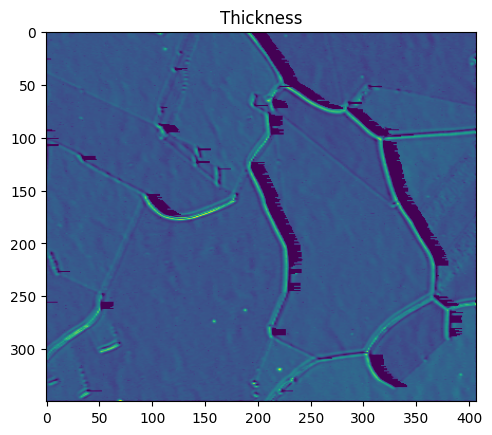

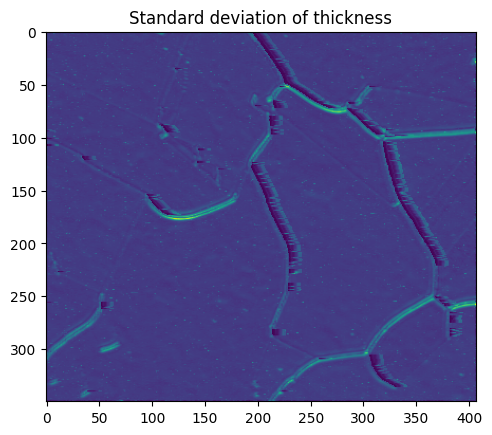

In [3]:
with (open("thickness_arr_png_manager.pkl",'rb')) as f:
    thickness_myfit_arr = pickle.load(f)
plt.imshow(thickness_myfit_arr)
plt.title('Thickness')
plt.show()

with (open("stderr_arr_png.pkl",'rb')) as f:
    stderr_myfit_arr = pickle.load(f)
plt.imshow(stderr_myfit_arr)
plt.title('Standard deviation of thickness')
plt.show()